**Bitcoin Price Prediction using Multivariate Data**

About this Notebook

*   Credits: Daniele Bertillo (daniele.bertillo@gmail.com)
*   Sources: https://www.analyticsvidhya.com/blog/2020/10/multivariate-multi-step-time-series-forecasting-using-stacked-lstm-sequence-to-sequence-autoencoder-in-tensorflow-2-0-keras/ , https://www.geeksforgeeks.org/principal-component-analysis-with-python/ , various other blogs and python notebook

About the Dataset


*   Source: https://www.cryptodatadownload.com/

**The goal is to use 50 ticks of 1 minute multivariate bitcoin data to predict the next 15 minute through a Recurrent Encoder Decoder model.** 

Steps followed:


1.   Load dataset
2.   Build features (new features are financial indicators)
3.   Select last 5k rows and divide it in train_set and test_set
4.   Produce y_train and y_test: normalize dataset and build y_train and y_test sets with 1 feature
5.   Produce X_train and X_test: normalize dataset, do PCA transformation to reduce trainset dimensionality and then select PCA features up to circa 85% original information as X_train and X_test
6.   (Remember that X_train, X_test, y_train and y_test need to be in the shape [n_samples, n_timesteps, n_features]
7.   Init the model and train it
8.   Make the prediction and inverse normalizazion on the output (no need to reverse PCA because that was only used to reduce dimensionality on the input)
9.   Show MAE and other statistcs to understand how good is the actual prediction

If you find any error or if you have any question please email me at daniele.bertillo@gmail.com

In [1]:
# NOTE: to predict just 1 sequence of n future vectors (one vector would be one tick with all features) you'll need to respect those requirements:
#  n_vectors to predict = n_future
#  test_set[n_samples, features] => n_samples = n_past + n_future
#  In this way in the test_set you can use the first n_past tick to predict the n_future tick
#  if n_samples > n_past + n_future the model will predict a number of sequence of n_future vectors equal to the that difference (n_sequence = n_samples - n_past - n_future)
#         which won't be very useful because only the last one will have all n_future vectors to predict 
#         (the other ones will predict some vector of which you already know all the values)

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import tensorflow as tf
import os

In [3]:
#Class that implemented some financial indicators

class Indicators:

    @staticmethod
    def sma_indicator(df: pd.DataFrame, time_period: int = 20):
        """
        Get The expected indicator in a pandas dataframe.
        Args:
            df(pandas.DataFrame): pandas Dataframe with close values\n
            time_period(int): look back time period to calculate moving average \n
        Returns:
            pandas.DataFrame: new pandas dataframe adding SMA as new column, preserving the columns which already exists\n
        """

        df["SMA"] = df["close"].rolling(window=time_period).mean()
        return df

    @staticmethod
    def macd_indicator(df: pd.DataFrame, short_time_period: int = 12, long_time_period: int = 26, need_signal: bool = True, signal_time_period: int = 9):
        """
        Get The expected indicator in a pandas dataframe.
        Args:
            df(pandas.DataFrame): pandas Dataframe with close values\n
            short_time_period(int): short term look back time period.\n
            long_time_period(int): long term look back time period.\n
            need_signal(bool): if True MACD signal line is added as a new column to the returning pandas dataframe.\n
            signal_time_period(int): look back period to calculate signal line\n
        Returns:
            pandas.DataFrame: new pandas dataframe adding MACD and MACD_signal_line(if required) as new column/s, preserving the columns which already exists\n
        """

        df["LONG_EMA"] = df["close"].ewm(span=long_time_period).mean()
        df["SHORT_EMA"] = df["close"].ewm(span=short_time_period).mean()

        df["MACD"] = df["SHORT_EMA"] - df["LONG_EMA"]
        if need_signal:
            df["MACD_signal_line"] = df["MACD"].ewm(span=signal_time_period).mean()

        df = df.drop(["LONG_EMA", "SHORT_EMA"], axis=1)
        return df

    @staticmethod
    def atr_indicator(df: pd.DataFrame, time_period: int = 14):
        """
        Get The expected indicator in a pandas dataframe.
        Args:
            df(pandas.DataFrame): pandas Dataframe with high, low and close values\n
            time_period(int): look back period to calculate ATR
        Returns:
            pandas.DataFrame: new pandas dataframe adding ATR as a new column, preserving the columns which already exists
        """

        df["close_prev"] = df["close"].shift(1)
        df["TR"] = df[["high", "close_prev"]].max(
            axis=1) - df[["low", "close_prev"]].min(axis=1)
        df["ATR"] = df["TR"].rolling(window=time_period).mean()

        df = df.drop(["close_prev", "TR"], axis=1)
        return df

    @staticmethod
    def ema_indicator(df: pd.DataFrame, time_period: int = 21):
        """
        Get The expected indicator in a pandas dataframe.
        Args:
            df(pandas.DataFrame): pandas Dataframe with close values\n
            time_period(int): look back time period\n
        Returns:
            pandas.DataFrame: new pandas dataframe adding EMA as a new column, preserving the columns which already exists\n
        """
        df["EMA"] = df["close"].ewm(span=time_period).mean()
        return df


    @staticmethod
    def kc_indicator(df: pd.DataFrame, time_period: int = 20, atr_time_period: int = 14, atr_multiplier: int = 2):
        """
        Get The expected indicator in a pandas dataframe.
        Args:
            df(pandas.DataFrame): pandas Dataframe with close values\n
            time_period(int): look back time period to calculate moving average
            atr_time_period(int): time period to calculate average true range
            atr_multiplier(int): constant value which will be multiplied by average true range
        Returns:
            pandas.DataFrame: new pandas dataframe adding kc_upper, kc_middle and kc_lower as three columns, preserving the columns which already exists\n
        """

        df["kc_middle"] = df["close"].ewm(span=time_period).mean()
        df = Indicators.atr_indicator(df, atr_time_period)

        df["kc_upper"] = df["kc_middle"] + atr_multiplier * df["ATR"]
        df["kc_lower"] = df["kc_middle"] - atr_multiplier * df["ATR"]

        df = df.drop(["ATR"], axis=1)

        return df


    @staticmethod
    def rsi_indicator(df, time_period=14):
        """
        Get The expected indicator in a pandas dataframe.
        Args:
            df(pandas.DataFrame): pandas Dataframe with close values\n
            time_period(int): look back time period to calculate moving average \n
        Returns:
            pandas.DataFrame: new pandas dataframe adding RSI as new column, preserving the columns which already exists\n
        """

        df["close_prev"] = df["close"].shift(1)

        df["GAIN"] = 0.0
        df["LOSS"] = 0.0

        df.loc[df["close"] > df["close_prev"],
               "GAIN"] = df["close"] - df["close_prev"]
        df.loc[df["close_prev"] > df["close"],
               "LOSS"] = df["close_prev"] - df["close"]
        df["AVG_GAIN"] = df["GAIN"].ewm(span=time_period).mean()
        df["AVG_LOSS"] = df["LOSS"].ewm(span=time_period).mean()
        df["AVG_GAIN"].iloc[:time_period] = np.nan
        df["AVG_LOSS"].iloc[:time_period] = np.nan
        df["RS"] = df["AVG_GAIN"] / \
                   (df["AVG_LOSS"] + 0.00000001)  # to avoid divide by zero

        df["RSI"] = 100 - ((100 / (1 + df["RS"])))

        df = df.drop(["close_prev", "GAIN", "LOSS",
                      "AVG_GAIN", "AVG_LOSS", "RS"], axis=1)
        return df


    @staticmethod
    def mom_indicator(df: pd.DataFrame, time_period=1):
        """
        MOM -> Momentum
        Momentum helps to determine the price changes from one period to another. \n
        \n Links:
            http://www.ta-guru.com/Book/TechnicalAnalysis/TechnicalIndicators/Momentum.php5\n
        """
        """
                Get The expected indicator in a pandas dataframe.
                Args:
                    df(pandas.DataFrame): pandas Dataframe with close values\n
                    time_period(int): look back time period.\n
                Returns:
                    pandas.DataFrame: new pandas dataframe adding MOM as a new column, 
                    preserving the columns which already exists\n
                """
        df["close_prev"] = df["close"].shift(time_period)
        df["MOM"] = df["close"] - df["close_prev"]
        df.drop(columns="close_prev")
        return df

    @staticmethod
    def vhf_indicator(df: pd.DataFrame, time_period: int = 28):
        """
                Get The expected indicator in a pandas dataframe.
                Args:
                    df(pandas.DataFrame): pandas Dataframe with close values\n
                    time_period(int): look back time period\n
                Returns:
                    pandas.DataFrame: new pandas dataframe adding VHF as new column, preserving the columns which already exists\n
                """
        df["PC"] = df["close"].shift(1)
        df["DIF"] = abs(df["close"] - df["PC"])

        df["HC"] = df["close"].rolling(window=time_period).max()
        df["LC"] = df["close"].rolling(window=time_period).min()

        df["HC-LC"] = abs(df["HC"] - df["LC"])

        df["DIF"] = df["DIF"].rolling(window=time_period).sum()

        df["VHF"] = df["HC-LC"] / df["DIF"]

        df = df.drop(["PC", "DIF", "HC", "LC", "HC-LC"], axis=1)

        return df


    @staticmethod
    def trix_indicator(df: pd.DataFrame, time_period: int = 14):
            """
            Get The expected indicator in a pandas dataframe.
            Args:
                df(pandas.DataFrame): pandas Dataframe with close values\n
                time_period(int): look back time period \n
            Returns:
                pandas.DataFrame: new pandas dataframe adding Trix as new column, preserving the columns which already exists\n
            """

            df["EMA1"] = df["close"].ewm(span=time_period).mean()
            df["EMA2"] = df["EMA1"].ewm(span=time_period).mean()
            df["EMA3"] = df["EMA2"].ewm(span=time_period).mean()
            df["EMA_prev"] = df["EMA3"].shift(1)

            df["TRIX"] = (df["EMA3"] - df["EMA_prev"]) / \
                         df["EMA_prev"] * 100
            df = df.drop(["EMA1", "EMA2", "EMA3", "EMA_prev"], axis=1)
            return df

    @staticmethod
    def rocv_indicator(df: pd.DataFrame, time_period: int = 12):
        """
           ROCV -> Rate of Change Volume
           ROCV indicator is used to identify whether the price movement is confirmed by trading volume.
            Links:
               http://www.ta-guru.com/Book/TechnicalAnalysis/TechnicalIndicators/VolumeRateOfChange.php5
               https://www.investopedia.com/articles/technical/02/091002.asp
           """

        """
        Get The expected indicator in a pandas dataframe.
        Args:
            df(pandas.DataFrame): pandas Dataframe with volume values\n
            time_period(int): look back time period\n
        Returns:
            pandas.DataFrame: new pandas dataframe adding ROCV as new column, preserving the columns which already exists\n
        """
        df["prev_volume"] = df["Volume BTC"].shift(time_period)
        df["ROCV"] = (df["Volume BTC"] - df["prev_volume"]
                      ) / df["prev_volume"] * 100
        df = df.drop(["prev_volume"], axis=1)


        return df

In [4]:
#--------------------- Data Preprocessing --------------------#
# Importing and scaling the data
#dataset_train = pd.read_csv("Bitcoin_Stock_Price_Trainset.csv")
#dataset_train = pd.read_csv('https://github.com/danber93/bitcoin_price_prediction/blob/main/data/Google_Stock_Price_Trainset.csv', skiprows=1)
dataset = pd.read_csv('https://github.com/ene610/DRL_finance/blob/main/data/Binance_BTCUSDT_minute.csv?raw=true', skiprows=1)
dataset = dataset.iloc[::-1]
print(dataset.shape)
dataset

(330483, 10)


,unix,date,symbol,open,high,low,close,Volume BTC,Volume USDT,tradecount
330482,1599856800000,2020-09-11 20:40:00,BTC/USDT,10317.00,10317.01,10314.36,10316.00,32.997684,3.403985e+05,342
330481,1599856860000,2020-09-11 20:41:00,BTC/USDT,10316.00,10321.09,10316.00,10319.50,16.328427,1.684977e+05,256
330480,1599856920000,2020-09-11 20:42:00,BTC/USDT,10319.50,10320.31,10318.49,10319.34,12.123487,1.251089e+05,193
330479,1599856980000,2020-09-11 20:43:00,BTC/USDT,10319.34,10320.14,10318.89,10319.00,13.548103,1.398070e+05,187
330478,1599857040000,2020-09-11 20:44:00,BTC/USDT,10318.99,10319.72,10316.58,10319.47,14.466964,1.492667e+05,284
...,...,...,...,...,...,...,...,...,...,...
4,1619742660000,2021-04-30 00:31:00,BTC/USDT,53745.99,53816.36,53700.00,53780.39,169.848725,9.132947e+06,2568
3,1619742720000,2021-04-30 00:32:00,BTC/USDT,53780.39,53784.04,53674.52,53674.53,53.895245,2.895554e+06,1595
2,1619742780000,2021-04-30 00:33:00,BTC/USDT,53674.53,53691.13,53615.98,53677.39,81.940577,4.396348e+06,1621
1,1619742840000,2021-04-30 00:34:00,BTC/USDT,53677.39,53722.40,53564.00,53580.98,89.941874,4.823830e+06,1777


In [5]:
# Building features
dataset['diff_pct_1'] = ((dataset['close'] / np.roll(dataset['close'], shift=(int(1)))) * 100) - 100
dataset['diff_pct_5'] = ((dataset['close'] / np.roll(dataset['close'], shift=(int(5)))) * 100) - 100
dataset['diff_pct_15'] = ((dataset['close'] / np.roll(dataset['close'], shift=(int(15)))) * 100) - 100
dataset['diff_pct_22'] = ((dataset['close'] / np.roll(dataset['close'], shift=(int(22)))) * 100) - 100

indicators = Indicators()

dataset = indicators.sma_indicator(dataset)
dataset = indicators.macd_indicator(dataset)
dataset = indicators.atr_indicator(dataset)
dataset = indicators.kc_indicator(dataset)
dataset = indicators.ema_indicator(dataset)
dataset = indicators.rsi_indicator(dataset)
dataset = indicators.rocv_indicator(dataset)
dataset = indicators.trix_indicator(dataset)
dataset = indicators.vhf_indicator(dataset)
dataset = indicators.mom_indicator(dataset)

print(dataset.columns)
print(dataset)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Index(['unix', 'date', 'symbol', 'open', 'high', 'low', 'close', 'Volume BTC',
       'Volume USDT', 'tradecount', 'diff_pct_1', 'diff_pct_5', 'diff_pct_15',
       'diff_pct_22', 'SMA', 'MACD', 'MACD_signal_line', 'kc_middle',
       'kc_upper', 'kc_lower', 'EMA', 'RSI', 'ROCV', 'TRIX', 'VHF',
       'close_prev', 'MOM'],
      dtype='object')
                 unix                 date  ... close_prev     MOM
330482  1599856800000  2020-09-11 20:40:00  ...        NaN     NaN
330481  1599856860000  2020-09-11 20:41:00  ...   10316.00    3.50
330480  1599856920000  2020-09-11 20:42:00  ...   10319.50   -0.16
330479  1599856980000  2020-09-11 20:43:00  ...   10319.34   -0.34
330478  1599857040000  2020-09-11 20:44:00  ...   10319.00    0.47
...               ...                  ...  ...        ...     ...
4       1619742660000  2021-04-30 00:31:00  ...   53746.00   34.39
3       1619742720000  2021-04-30 00:32:00  ...   53780.39 -105.86
2       1619742780000  2021-04-30 00:33:00  ...   

In [6]:
# Drop useless columns

print(dataset.columns)
dataset = dataset.drop(['unix', 'date', 'symbol'], axis=1)
print(dataset)

Index(['unix', 'date', 'symbol', 'open', 'high', 'low', 'close', 'Volume BTC',
       'Volume USDT', 'tradecount', 'diff_pct_1', 'diff_pct_5', 'diff_pct_15',
       'diff_pct_22', 'SMA', 'MACD', 'MACD_signal_line', 'kc_middle',
       'kc_upper', 'kc_lower', 'EMA', 'RSI', 'ROCV', 'TRIX', 'VHF',
       'close_prev', 'MOM'],
      dtype='object')
            open      high       low  ...       VHF  close_prev     MOM
330482  10317.00  10317.01  10314.36  ...       NaN         NaN     NaN
330481  10316.00  10321.09  10316.00  ...       NaN    10316.00    3.50
330480  10319.50  10320.31  10318.49  ...       NaN    10319.50   -0.16
330479  10319.34  10320.14  10318.89  ...       NaN    10319.34   -0.34
330478  10318.99  10319.72  10316.58  ...       NaN    10319.00    0.47
...          ...       ...       ...  ...       ...         ...     ...
4       53745.99  53816.36  53700.00  ...  0.392609    53746.00   34.39
3       53780.39  53784.04  53674.52  ...  0.371109    53780.39 -105.86
2    

In [7]:
# Select last  5k rows
dataset = dataset.tail(5000)

# Split into train and test dataset
dataset_train, dataset_test = dataset[1:4936], dataset[4935:]
print(dataset_train.shape)
print(dataset_test.shape)
dataset_train = pd.DataFrame(dataset_train)
dataset_test = pd.DataFrame(dataset_test)

(4935, 24)
(65, 24)


In [8]:
# Function to build X_train, X_test, y_train and y_test in the shape [n_samples, n_timesteps, n_features]

def split_series(series, n_past, n_future):
  #
  # n_past ==> no of past observations
  #
  # n_future ==> no of future observations 
  #
  X, y = list(), list()
  print(range(len(series)))
  for window_start in range(len(series)):
    past_end = window_start + n_past
    future_end = past_end + n_future
    if future_end > len(series):
      break
    # slicing the past and future parts of the window
    past, future = series[window_start:past_end, :], series[past_end:future_end, :]
    X.append(past)
    y.append(future)
  return np.array(X), np.array(y)

In [9]:
n_past = 50
n_future = 15
n_features = 4
n_features_y = 24

In [10]:
# Produce y_train and y_test (which will use only some normalized columns -close or diff_pct_15 features)

train = dataset_train
scalers_y={}
for i in dataset_train.columns:
    scaler = MinMaxScaler(feature_range=(-1,1))
    s_s = scaler.fit_transform(train[i].values.reshape(-1,1))
    s_s=np.reshape(s_s,len(s_s))
    scalers_y['scaler_'+ str(i)] = scaler
    train[i]=s_s
test = dataset_test
for i in dataset_test.columns:
    scaler = scalers_y['scaler_'+ str(i)]
    s_s = scaler.transform(test[i].values.reshape(-1,1))
    s_s=np.reshape(s_s,len(s_s))
    scalers_y['scaler_'+ str(i)] = scaler
    test[i]=s_s
print(test.shape)

(65, 24)


In [11]:
_, y_train = split_series(train.values,n_past, n_future)
#X_train = X_train.reshape((X_train.shape[0], X_train.shape[1],n_features))
y_train = y_train.reshape((y_train.shape[0], y_train.shape[1], n_features_y))
_, y_test = split_series(test.values, n_past, n_future)
#X_test = X_test.reshape((X_test.shape[0], X_test.shape[1],n_features))
y_test = y_test.reshape((y_test.shape[0], y_test.shape[1], n_features_y))

print(y_train.shape)
print(y_test.shape)

range(0, 4935)
range(0, 65)
(4871, 15, 24)
(1, 15, 24)


In [12]:
# Select only diff_pct_15 feature from y_train and y_test

y_train = y_train[:, :, 9:10]
y_test = y_test[:, :, 9:10]

print(y_train.shape)
print(y_test.shape)

(4871, 15, 1)
(1, 15, 1)


In [13]:
# PCA to produce X_train and X_test
from sklearn.decomposition import PCA

# Normalitazion
train_norm = dataset_train
scalers_X={}
for i in dataset_train.columns:
    scaler = MinMaxScaler(feature_range=(-1,1))
    s_s = scaler.fit_transform(train_norm[i].values.reshape(-1,1))
    s_s=np.reshape(s_s,len(s_s))
    scalers_X['scaler_'+ str(i)] = scaler
    train_norm[i]=s_s
test_norm = dataset_test
for i in dataset_test.columns:
    scaler = scalers_X['scaler_'+ str(i)]
    s_s = scaler.transform(test_norm[i].values.reshape(-1,1))
    s_s=np.reshape(s_s,len(s_s))
    scalers_X['scaler_'+ str(i)] = scaler
    test_norm[i]=s_s

#PCA
pca = PCA(n_components = 4)

train_pca = pca.fit_transform(train_norm)
test_pca = pca.transform(test_norm)

explained_variance = pca.explained_variance_ratio_
print("explained_variance", explained_variance)
print("explained_variance.sum()", explained_variance.sum())

#Split between X_train, X_test, y_train, y_test (discard y_train and y_test)
X_train, _ = split_series(train_pca,n_past, n_future)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1],n_features))
X_test, _ = split_series(test_pca, n_past, n_future)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1],n_features))

print("X_train.shape", X_train.shape)
print("X_test.shape", X_test.shape)

explained_variance [0.5094112  0.20183035 0.09950163 0.05621052]
explained_variance.sum() 0.86695370023263
range(0, 4935)
range(0, 65)
X_train.shape (4871, 50, 4)
X_test.shape (1, 50, 4)


In [14]:
# Encoder Decoder LSTM
# n_features ==> no of features at each timestep in the data.
#
encoder_inputs = tf.keras.layers.Input(shape=(n_past, n_features))
encoder_l1 = tf.keras.layers.LSTM(100, return_state=True)
encoder_outputs1 = encoder_l1(encoder_inputs)

encoder_states1 = encoder_outputs1[1:]

#
decoder_inputs = tf.keras.layers.RepeatVector(n_future)(encoder_outputs1[0])

#
decoder_l1 = tf.keras.layers.LSTM(100, return_sequences=True)(decoder_inputs,initial_state = encoder_states1)
decoder_outputs1 = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(y_test.shape[2]))(decoder_l1)

#
model= tf.keras.models.Model(encoder_inputs,decoder_outputs1)

#
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 50, 4)]      0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 100), (None, 42000       input_1[0][0]                    
__________________________________________________________________________________________________
repeat_vector (RepeatVector)    (None, 15, 100)      0           lstm[0][0]                       
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (None, 15, 100)      80400       repeat_vector[0][0]              
                                                                 lstm[0][1]                   

In [15]:
filepath = '/content/checkpoint/model{epoch:d}'
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=filepath,
    period = 5)

In [16]:
reduce_lr = tf.keras.callbacks.LearningRateScheduler(lambda x: 1e-3 * 0.90 ** x)
model.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.Huber())
history=model.fit(X_train,y_train,epochs=85,validation_data=(X_test,y_test),batch_size=32,verbose=1,callbacks=[checkpoint, reduce_lr])

Epoch 1/85
153/153 [==============================] - 13s 61ms/step - loss: 0.0050 - val_loss: 0.0149
Epoch 2/85
153/153 [==============================] - 8s 55ms/step - loss: 0.0045 - val_loss: 0.0179
Epoch 3/85
153/153 [==============================] - 8s 52ms/step - loss: 0.0043 - val_loss: 0.0177
Epoch 4/85
153/153 [==============================] - 8s 52ms/step - loss: 0.0041 - val_loss: 0.0160
Epoch 5/85
153/153 [==============================] - 8s 51ms/step - loss: 0.0040 - val_loss: 0.0200


INFO:tensorflow:Assets written to: /content/checkpoint/model5/assets


INFO:tensorflow:Assets written to: /content/checkpoint/model5/assets


Epoch 6/85
153/153 [==============================] - 8s 55ms/step - loss: 0.0040 - val_loss: 0.0172
Epoch 7/85
153/153 [==============================] - 9s 57ms/step - loss: 0.0039 - val_loss: 0.0203
Epoch 8/85
153/153 [==============================] - 9s 57ms/step - loss: 0.0039 - val_loss: 0.0202
Epoch 9/85
153/153 [==============================] - 9s 57ms/step - loss: 0.0039 - val_loss: 0.0202
Epoch 10/85
153/153 [==============================] - 9s 59ms/step - loss: 0.0039 - val_loss: 0.0188


INFO:tensorflow:Assets written to: /content/checkpoint/model10/assets


INFO:tensorflow:Assets written to: /content/checkpoint/model10/assets


Epoch 11/85
153/153 [==============================] - 9s 58ms/step - loss: 0.0038 - val_loss: 0.0220
Epoch 12/85
153/153 [==============================] - 9s 57ms/step - loss: 0.0038 - val_loss: 0.0192
Epoch 13/85
153/153 [==============================] - 9s 58ms/step - loss: 0.0037 - val_loss: 0.0190
Epoch 14/85
153/153 [==============================] - 9s 57ms/step - loss: 0.0037 - val_loss: 0.0165
Epoch 15/85
153/153 [==============================] - 9s 56ms/step - loss: 0.0037 - val_loss: 0.0160


INFO:tensorflow:Assets written to: /content/checkpoint/model15/assets


INFO:tensorflow:Assets written to: /content/checkpoint/model15/assets


Epoch 16/85
153/153 [==============================] - 9s 59ms/step - loss: 0.0037 - val_loss: 0.0177
Epoch 17/85
153/153 [==============================] - 9s 57ms/step - loss: 0.0037 - val_loss: 0.0170
Epoch 18/85
153/153 [==============================] - 9s 58ms/step - loss: 0.0036 - val_loss: 0.0188
Epoch 19/85
153/153 [==============================] - 9s 60ms/step - loss: 0.0036 - val_loss: 0.0179
Epoch 20/85
153/153 [==============================] - 10s 64ms/step - loss: 0.0036 - val_loss: 0.0201


INFO:tensorflow:Assets written to: /content/checkpoint/model20/assets


INFO:tensorflow:Assets written to: /content/checkpoint/model20/assets


Epoch 21/85
153/153 [==============================] - 9s 58ms/step - loss: 0.0035 - val_loss: 0.0193
Epoch 22/85
153/153 [==============================] - 9s 57ms/step - loss: 0.0035 - val_loss: 0.0201
Epoch 23/85
153/153 [==============================] - 8s 55ms/step - loss: 0.0035 - val_loss: 0.0206
Epoch 24/85
153/153 [==============================] - 9s 56ms/step - loss: 0.0034 - val_loss: 0.0243
Epoch 25/85
153/153 [==============================] - 9s 57ms/step - loss: 0.0034 - val_loss: 0.0220


INFO:tensorflow:Assets written to: /content/checkpoint/model25/assets


INFO:tensorflow:Assets written to: /content/checkpoint/model25/assets


Epoch 26/85
153/153 [==============================] - 10s 67ms/step - loss: 0.0033 - val_loss: 0.0234
Epoch 27/85
153/153 [==============================] - 9s 58ms/step - loss: 0.0033 - val_loss: 0.0224
Epoch 28/85
153/153 [==============================] - 9s 57ms/step - loss: 0.0033 - val_loss: 0.0230
Epoch 29/85
153/153 [==============================] - 9s 57ms/step - loss: 0.0033 - val_loss: 0.0227
Epoch 30/85
153/153 [==============================] - 9s 57ms/step - loss: 0.0032 - val_loss: 0.0246


INFO:tensorflow:Assets written to: /content/checkpoint/model30/assets


INFO:tensorflow:Assets written to: /content/checkpoint/model30/assets


Epoch 31/85
153/153 [==============================] - 9s 58ms/step - loss: 0.0032 - val_loss: 0.0229
Epoch 32/85
153/153 [==============================] - 9s 58ms/step - loss: 0.0032 - val_loss: 0.0236
Epoch 33/85
153/153 [==============================] - 9s 60ms/step - loss: 0.0032 - val_loss: 0.0238
Epoch 34/85
153/153 [==============================] - 9s 58ms/step - loss: 0.0032 - val_loss: 0.0232
Epoch 35/85
153/153 [==============================] - 9s 58ms/step - loss: 0.0032 - val_loss: 0.0230


INFO:tensorflow:Assets written to: /content/checkpoint/model35/assets


INFO:tensorflow:Assets written to: /content/checkpoint/model35/assets


Epoch 36/85
153/153 [==============================] - 9s 58ms/step - loss: 0.0032 - val_loss: 0.0226
Epoch 37/85
153/153 [==============================] - 9s 57ms/step - loss: 0.0032 - val_loss: 0.0225
Epoch 38/85
153/153 [==============================] - 9s 57ms/step - loss: 0.0032 - val_loss: 0.0227
Epoch 39/85
153/153 [==============================] - 9s 58ms/step - loss: 0.0032 - val_loss: 0.0229
Epoch 40/85
153/153 [==============================] - 9s 57ms/step - loss: 0.0032 - val_loss: 0.0226


INFO:tensorflow:Assets written to: /content/checkpoint/model40/assets


INFO:tensorflow:Assets written to: /content/checkpoint/model40/assets


Epoch 41/85
153/153 [==============================] - 9s 58ms/step - loss: 0.0032 - val_loss: 0.0225
Epoch 42/85
153/153 [==============================] - 9s 59ms/step - loss: 0.0032 - val_loss: 0.0224
Epoch 43/85
153/153 [==============================] - 9s 60ms/step - loss: 0.0032 - val_loss: 0.0227
Epoch 44/85
153/153 [==============================] - 9s 60ms/step - loss: 0.0032 - val_loss: 0.0228
Epoch 45/85
153/153 [==============================] - 9s 62ms/step - loss: 0.0032 - val_loss: 0.0225


INFO:tensorflow:Assets written to: /content/checkpoint/model45/assets


INFO:tensorflow:Assets written to: /content/checkpoint/model45/assets


Epoch 46/85
153/153 [==============================] - 9s 58ms/step - loss: 0.0032 - val_loss: 0.0229
Epoch 47/85
153/153 [==============================] - 9s 58ms/step - loss: 0.0032 - val_loss: 0.0226
Epoch 48/85
153/153 [==============================] - 9s 57ms/step - loss: 0.0032 - val_loss: 0.0228
Epoch 49/85
153/153 [==============================] - 9s 59ms/step - loss: 0.0032 - val_loss: 0.0228
Epoch 50/85
153/153 [==============================] - 9s 59ms/step - loss: 0.0031 - val_loss: 0.0227


INFO:tensorflow:Assets written to: /content/checkpoint/model50/assets


INFO:tensorflow:Assets written to: /content/checkpoint/model50/assets


Epoch 51/85
153/153 [==============================] - 9s 58ms/step - loss: 0.0031 - val_loss: 0.0226
Epoch 52/85
153/153 [==============================] - 9s 58ms/step - loss: 0.0031 - val_loss: 0.0226
Epoch 53/85
153/153 [==============================] - 9s 57ms/step - loss: 0.0031 - val_loss: 0.0227
Epoch 54/85
153/153 [==============================] - 9s 57ms/step - loss: 0.0031 - val_loss: 0.0226
Epoch 55/85
153/153 [==============================] - 9s 59ms/step - loss: 0.0031 - val_loss: 0.0226


INFO:tensorflow:Assets written to: /content/checkpoint/model55/assets


INFO:tensorflow:Assets written to: /content/checkpoint/model55/assets


Epoch 56/85
153/153 [==============================] - 9s 57ms/step - loss: 0.0031 - val_loss: 0.0226
Epoch 57/85
153/153 [==============================] - 9s 58ms/step - loss: 0.0031 - val_loss: 0.0226
Epoch 58/85
153/153 [==============================] - 9s 56ms/step - loss: 0.0031 - val_loss: 0.0226
Epoch 59/85
153/153 [==============================] - 9s 56ms/step - loss: 0.0031 - val_loss: 0.0225
Epoch 60/85
153/153 [==============================] - 9s 59ms/step - loss: 0.0031 - val_loss: 0.0225


INFO:tensorflow:Assets written to: /content/checkpoint/model60/assets


INFO:tensorflow:Assets written to: /content/checkpoint/model60/assets


Epoch 61/85
153/153 [==============================] - 9s 60ms/step - loss: 0.0031 - val_loss: 0.0225
Epoch 62/85
153/153 [==============================] - 9s 57ms/step - loss: 0.0031 - val_loss: 0.0225
Epoch 63/85
153/153 [==============================] - 9s 58ms/step - loss: 0.0031 - val_loss: 0.0225
Epoch 64/85
153/153 [==============================] - 8s 54ms/step - loss: 0.0031 - val_loss: 0.0225
Epoch 65/85
153/153 [==============================] - 9s 56ms/step - loss: 0.0031 - val_loss: 0.0225


INFO:tensorflow:Assets written to: /content/checkpoint/model65/assets


INFO:tensorflow:Assets written to: /content/checkpoint/model65/assets


Epoch 66/85
153/153 [==============================] - 9s 58ms/step - loss: 0.0031 - val_loss: 0.0225
Epoch 67/85
153/153 [==============================] - 8s 54ms/step - loss: 0.0031 - val_loss: 0.0225
Epoch 68/85
153/153 [==============================] - 8s 52ms/step - loss: 0.0031 - val_loss: 0.0225
Epoch 69/85
153/153 [==============================] - 8s 53ms/step - loss: 0.0031 - val_loss: 0.0225
Epoch 70/85
153/153 [==============================] - 9s 58ms/step - loss: 0.0031 - val_loss: 0.0225


INFO:tensorflow:Assets written to: /content/checkpoint/model70/assets


INFO:tensorflow:Assets written to: /content/checkpoint/model70/assets


Epoch 71/85
153/153 [==============================] - 9s 57ms/step - loss: 0.0031 - val_loss: 0.0225
Epoch 72/85
153/153 [==============================] - 8s 55ms/step - loss: 0.0031 - val_loss: 0.0225
Epoch 73/85
153/153 [==============================] - 8s 52ms/step - loss: 0.0031 - val_loss: 0.0225
Epoch 74/85
153/153 [==============================] - 8s 54ms/step - loss: 0.0031 - val_loss: 0.0225
Epoch 75/85
153/153 [==============================] - 8s 53ms/step - loss: 0.0031 - val_loss: 0.0225


INFO:tensorflow:Assets written to: /content/checkpoint/model75/assets


INFO:tensorflow:Assets written to: /content/checkpoint/model75/assets


Epoch 76/85
153/153 [==============================] - 8s 53ms/step - loss: 0.0031 - val_loss: 0.0225
Epoch 77/85
153/153 [==============================] - 8s 53ms/step - loss: 0.0031 - val_loss: 0.0225
Epoch 78/85
153/153 [==============================] - 8s 54ms/step - loss: 0.0031 - val_loss: 0.0225
Epoch 79/85
153/153 [==============================] - 8s 52ms/step - loss: 0.0031 - val_loss: 0.0225
Epoch 80/85
153/153 [==============================] - 8s 53ms/step - loss: 0.0031 - val_loss: 0.0225


INFO:tensorflow:Assets written to: /content/checkpoint/model80/assets


INFO:tensorflow:Assets written to: /content/checkpoint/model80/assets


Epoch 81/85
153/153 [==============================] - 8s 53ms/step - loss: 0.0031 - val_loss: 0.0225
Epoch 82/85
153/153 [==============================] - 8s 53ms/step - loss: 0.0031 - val_loss: 0.0225
Epoch 83/85
153/153 [==============================] - 8s 53ms/step - loss: 0.0031 - val_loss: 0.0225
Epoch 84/85
153/153 [==============================] - 8s 52ms/step - loss: 0.0031 - val_loss: 0.0225
Epoch 85/85
153/153 [==============================] - 8s 52ms/step - loss: 0.0031 - val_loss: 0.0225


INFO:tensorflow:Assets written to: /content/checkpoint/model85/assets


INFO:tensorflow:Assets written to: /content/checkpoint/model85/assets


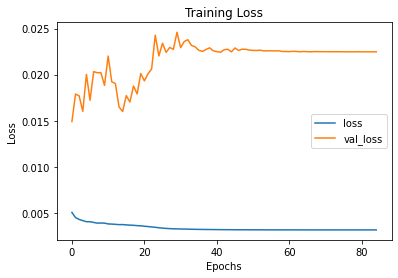

In [17]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Training Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['loss', 'val_loss'])
plt.show()

In [18]:
# Make the prediction

pred=model.predict(X_test)
print(pred.shape)

(1, 15, 1)


In [19]:
# Reverse normalized transformation

scaler = scalers_y['scaler_diff_pct_15']
pred[:,:,0]=scaler.inverse_transform(pred[:,:,0])

print(pred.shape)
print(pred)

(1, 15, 1)
[[[-0.35210785]
  [-0.31135795]
  [-0.28723824]
  [-0.27912435]
  [-0.28050587]
  [-0.28275904]
  [-0.27789494]
  [-0.26028916]
  [-0.22747694]
  [-0.18020664]
  [-0.12198555]
  [-0.0583262 ]
  [ 0.00415364]
  [ 0.0586768 ]
  [ 0.09923097]]]


In [20]:
print(y_test)

[[[-0.06312103]
  [-0.01013853]
  [ 0.01616779]
  [ 0.01467549]
  [ 0.02366138]
  [ 0.0520514 ]
  [ 0.09635763]
  [ 0.1055815 ]
  [ 0.23640477]
  [ 0.28916038]
  [ 0.3929975 ]
  [ 0.41967141]
  [ 0.44982837]
  [ 0.36107826]
  [ 0.28769647]]]


In [21]:
# Does the diff_pct_15 follows the trend (decrese/increse)?

trend_test = y_test[:, 0, 0] - y_test[:, 14, 0]
trend_pred = pred[:, 0, 0] - pred[:, 14, 0]
print("trend_test", trend_test)
print("trend_pred", trend_pred)
if (trend_test < 0 and trend_pred < 0) or (trend_test > 0 and trend_pred > 0):
  trend = 1
else:
  trend = 0

test_trend = y_test[:, 0, 0] > y_test[:, 14, 0]
pred_trend = pred[:, 0, 0] > pred[:, 14, 0]
print(f"Are they following the same trend? {test_trend==pred_trend}")

trend_test [-0.3508175]
trend_pred [-0.45133883]
Are they following the same trend? [ True]


In [22]:
# MAE calculation of the sequence vectorized output for each epoch
import keras
from sklearn.metrics import mean_absolute_error

for epoch in range(5, 85, 5):
  print(f"Model trained for {epoch} epochs:")
  model = keras.models.load_model(f'/content/checkpoint/model{epoch:d}')
  pred = model.predict(X_test)
  pred[:,:,0]=scalers_y['scaler_diff_pct_15'].inverse_transform(pred[:,:,0])
  avg_mae = 0
  for i in range(0, y_test.shape[1]):
    mae = mean_absolute_error(y_test[:, i, 0], pred[:, i, 0])
    print(f"   MAE[{i}]=", mae)
    avg_mae = avg_mae + mae
  print(f'Average MAE ={avg_mae/15}')
  print()

Model trained for 5 epochs:
   MAE[0]= 0.29975586537118204
   MAE[1]= 0.3521680380167579
   MAE[2]= 0.3713885266508819
   MAE[3]= 0.35465460617290784
   MAE[4]= 0.33936083569527487
   MAE[5]= 0.3346305534032877
   MAE[6]= 0.338153665619244
   MAE[7]= 0.3008278841660801
   MAE[8]= 0.38165131736891555
   MAE[9]= 0.38341823678373493
   MAE[10]= 0.4376574569994758
   MAE[11]= 0.4182502454731766
   MAE[12]= 0.4075952804385984
   MAE[13]= 0.28460772940483553
   MAE[14]= 0.18438648884429798
Average MAE =0.34590044869391007

Model trained for 10 epochs:
   MAE[0]= 0.28146463040108927
   MAE[1]= 0.3260118211569404
   MAE[2]= 0.34846216628215326
   MAE[3]= 0.3426266272758131
   MAE[4]= 0.34085724010468343
   MAE[5]= 0.34760255066433504
   MAE[6]= 0.3572500848344463
   MAE[7]= 0.3191168690608326
   MAE[8]= 0.3922825210203438
   MAE[9]= 0.38099524836897053
   MAE[10]= 0.4192074371183465
   MAE[11]= 0.3837502031473595
   MAE[12]= 0.36005355405801176
   MAE[13]= 0.22972032287683947
   MAE[14]= 0.129

   MAE[0]= 0.25368758443589456
   MAE[1]= 0.2670816327395057
   MAE[2]= 0.27627527901790155
   MAE[3]= 0.2760167678092604
   MAE[4]= 0.29469859852791647
   MAE[5]= 0.3302323266653116
   MAE[6]= 0.36992009516273916
   MAE[7]= 0.35696435817940864
   MAE[8]= 0.446219628344944
   MAE[9]= 0.4399639637386719
   MAE[10]= 0.4723853880221198
   MAE[11]= 0.4224446894021857
   MAE[12]= 0.3791312425135934
   MAE[13]= 0.22846135356989367
   MAE[14]= 0.11206225012674198
Average MAE =0.3283696772170726

Model trained for 25 epochs:


   MAE[0]= 0.25790917280907877
   MAE[1]= 0.27288706553598396
   MAE[2]= 0.2808147687639953
   MAE[3]= 0.27865269381748486
   MAE[4]= 0.29661256327629903
   MAE[5]= 0.33370763508358553
   MAE[6]= 0.37761028643166006
   MAE[7]= 0.37127096304162177
   MAE[8]= 0.4688134842027931
   MAE[9]= 0.4714654506361405
   MAE[10]= 0.5122152382189582
   MAE[11]= 0.46884554539603773
   MAE[12]= 0.42935332457714914
   MAE[13]= 0.2791108102497147
   MAE[14]= 0.15961786066427097
Average MAE =0.3505924575136516

Model trained for 30 epochs:
   MAE[0]= 0.2984727561831022
   MAE[1]= 0.3192792381109809
   MAE[2]= 0.32889610716960443
   MAE[3]= 0.3254462738727217
   MAE[4]= 0.3405306364536367
   MAE[5]= 0.37442702499905184
   MAE[6]= 0.4157772862485546
   MAE[7]= 0.4081521714614216
   MAE[8]= 0.5059665047039299
   MAE[9]= 0.5104639501488129
   MAE[10]= 0.5544296914393256
   MAE[11]= 0.5152639402894456
   MAE[12]= 0.48041955369704603
   MAE[13]= 0.33457166747715933
   MAE[14]= 0.21840158556833134
Average MAE =